[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://github.com/CodingPro777/AAI-530-GROUP-1/edit/main/final_project_code.ipynb
)


# USD AAI-530 Group 1 final project - Machine Learning with IoT(FitBit Fitness)

*Group 1 members: Ali Abdul-Hameed, Jack Kim, Jinyuan He*


In [1]:
# load packages
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


# 1. Data cleaning & EDA

## 1.1 Loading dataset

In [6]:
import os
import pandas as pd

# Detect possible extracted folders (works whether the zip contains wrapper folders or not)
CANDIDATES = [
    "mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16",
    "mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16",
    "Fitabase Data 3.12.16-4.11.16",
    "Fitabase Data 4.12.16-5.12.16",
]

BASES = [p for p in CANDIDATES if os.path.exists(p)]
if not BASES:
    !find . -maxdepth 2 -type d
    raise FileNotFoundError("No Fitabase Data folders found after unzip. Check where the zip extracted.")

print("Using these data folders:")
for b in BASES:
    print(" -", b)

def read_all(fname):
    paths = [os.path.join(b, fname) for b in BASES if os.path.exists(os.path.join(b, fname))]
    if not paths:
        raise FileNotFoundError(f"Missing {fname} in all detected folders: {BASES}")
    return pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)

raw_daily_activity_df  = read_all("dailyActivity_merged.csv")
raw_weight_df          = read_all("weightLogInfo_merged.csv")
raw_hr_sec_df          = read_all("heartrate_seconds_merged.csv")
raw_calories_min_df    = read_all("minuteCaloriesNarrow_merged.csv")
raw_intensities_min_df = read_all("minuteIntensitiesNarrow_merged.csv")
raw_mets_min_df        = read_all("minuteMETsNarrow_merged.csv")
raw_sleep_min_df       = read_all("minuteSleep_merged.csv")
raw_step_min_df        = read_all("minuteStepsNarrow_merged.csv")


Using these data folders:
 - Fitabase Data 4.12.16-5.12.16


## 1.2 Dataset for calories prediction

In [7]:
calories_df = raw_calories_min_df.merge(
    raw_intensities_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df = calories_df.merge(
    raw_mets_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df = calories_df.merge(
    raw_step_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df['ActivityMinute'] = pd.to_datetime(
    calories_df['ActivityMinute'],
    format='%m/%d/%Y %I:%M:%S %p'
)

raw_weight_df['Date'] = pd.to_datetime(
    raw_weight_df['Date'],
    format='%m/%d/%Y %I:%M:%S %p'
)

# sort these two datasets
calories_df = calories_df.sort_values(
    ['ActivityMinute', 'Id']
).reset_index(drop=True)

raw_weight_df = raw_weight_df.sort_values(
    ['Date', 'Id']
).reset_index(drop=True)

calories_merged_df = pd.merge_asof(
    calories_df,
    raw_weight_df[['Id', 'Date', 'WeightPounds', 'BMI']],
    left_on='ActivityMinute',
    right_on='Date',
    by='Id',                # match same user
    direction='backward'    # use latest weight BEFORE activity time
)

In [8]:
calories_merged_df.isna().sum()

,0
Id,0
ActivityMinute,0
Calories,0
Intensity,0
METs,0
Steps,0
Date,1050675
WeightPounds,1050675
BMI,1050675


In [9]:
# Forward fill weight-related columns by user
cols_to_fill = ['WeightPounds', 'BMI']

calories_merged_df[cols_to_fill] = (
    calories_merged_df
        .groupby('Id')[cols_to_fill]
        .transform(lambda x: x.ffill().bfill())
)

In [10]:
calories_merged_df.isna().sum()

,0
Id,0
ActivityMinute,0
Calories,0
Intensity,0
METs,0
Steps,0
Date,1050675
WeightPounds,976200
BMI,976200


In [11]:
# remove the data which doesn't have WeightPounds, BMI
calories_merged_df.dropna(subset=['WeightPounds', 'BMI'], inplace=True)
calories_merged_df.drop(columns=['Date'], inplace=True)
calories_merged_df.isna().sum()

,0
Id,0
ActivityMinute,0
Calories,0
Intensity,0
METs,0
Steps,0
WeightPounds,0
BMI,0


In [12]:
number_cols = [
    'Calories',
    'Intensity',
    'METs',
    'Steps',
    'WeightPounds',
    'BMI'
]

calories_merged_df[number_cols] = calories_merged_df[number_cols].apply(pd.to_numeric)

In [13]:
pd.options.display.float_format = '{:.0f}'.format
calories_merged_df.describe()

,Id,ActivityMinute,Calories,Intensity,METs,Steps,WeightPounds,BMI
count,349380,349380,349380,349380,349380,349380,349380,349380
mean,4577670796,2016-04-27 03:59:46.383308032,2,0,16,6,172,28
min,1503960366,2016-04-12 00:00:00,0,0,0,0,116,21
25%,2873212765,2016-04-19 13:58:00,1,0,10,0,134,24
50%,4319703577,2016-04-27 03:56:00,1,0,10,0,155,26
75%,6962181067,2016-05-04 17:54:00,1,0,12,0,189,27
max,8877689391,2016-05-12 15:59:00,18,3,157,207,294,48
std,2364996201,NaN,2,1,14,20,54,8


### 1.2.1 Check minute-level time continuity in the dataset

In [14]:
# Sort by value
calories_merged_df = calories_merged_df.sort_values(['Id', 'ActivityMinute'], ascending=True)

# Remove duplicated data
calories_merged_df = calories_merged_df.drop_duplicates(subset=['Id', 'ActivityMinute'])

# Check minute-level time continuity in the dataset
calories_merged_df.groupby('Id')['ActivityMinute'].diff().value_counts().head()

,count
ActivityMinute,
0 days 00:01:00,349372


#### PS: The minute-level activity data is largely continuous, with over 99% of consecutive records occurring at 1-minute intervals. A small number of duplicate timestamps and occasional multi-hour gaps were observed, likely due to device synchronization or user inactivity.

In [15]:
# We mark time gaps in the data so that the records can be separated into sessions or removed when training time-series models.
calories_merged_df['minute_gap'] = (
    calories_merged_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
      .div(60)
)

calories_merged_df['has_gap'] = (calories_merged_df['minute_gap'] > 1).astype(int)

### 1.2.2 EDA

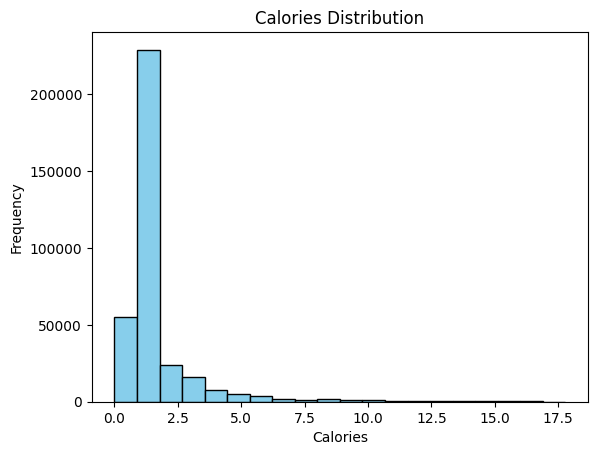

In [16]:

plt.hist(calories_merged_df['Calories'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Calories Distribution')
plt.show()

array([[<Axes: title={'center': 'Steps'}>,
        <Axes: title={'center': 'METs'}>],
       [<Axes: title={'center': 'Intensity'}>, <Axes: >]], dtype=object)

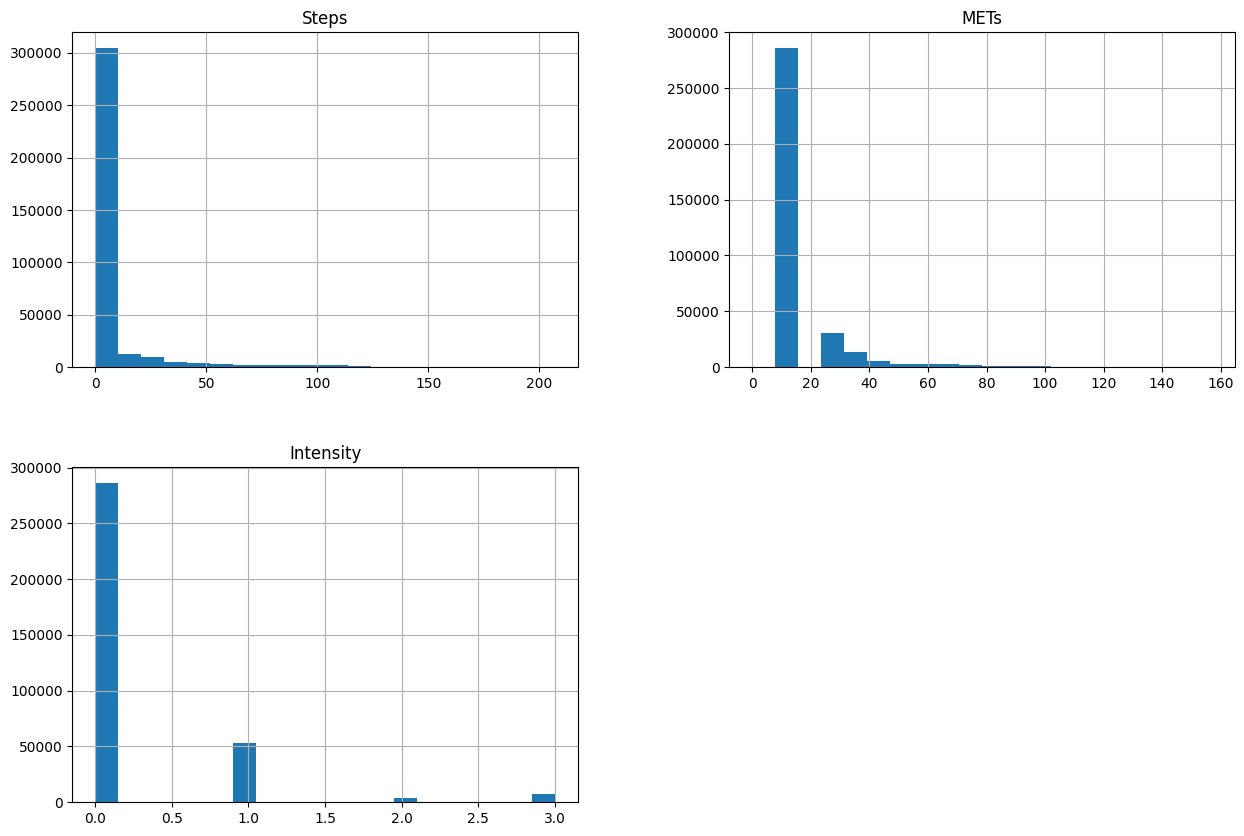

In [17]:
calories_merged_df[['Steps', 'METs', 'Intensity']].hist(bins=20, figsize=(15,10))

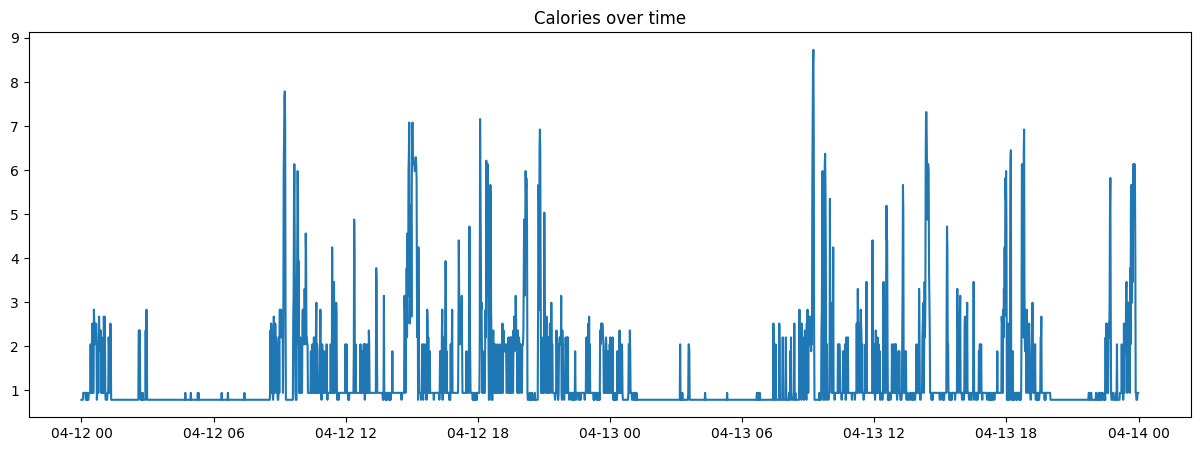

In [18]:
uid = calories_merged_df['Id'].iloc[0]

sample = (
    calories_merged_df[calories_merged_df['Id'] == uid]
        .head(2 * 24 * 60)
)
plt.figure(figsize=(15, 5))
plt.plot(sample['ActivityMinute'], sample['Calories'], label='Calories')
plt.title('Calories over time')
plt.show()

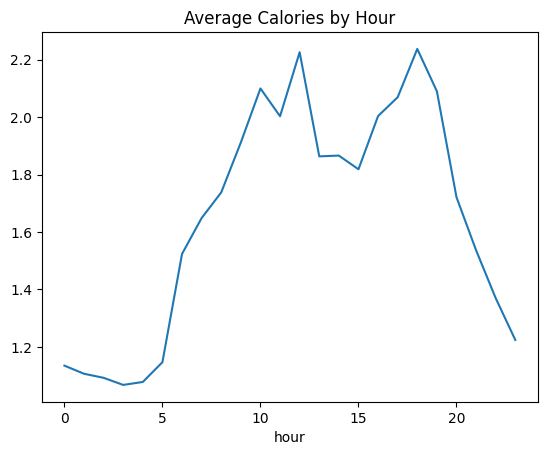

In [19]:
calories_merged_df['hour'] = calories_merged_df['ActivityMinute'].dt.hour

calories_merged_df.groupby('hour')['Calories'].mean().plot(kind='line')
plt.title('Average Calories by Hour')
plt.show()

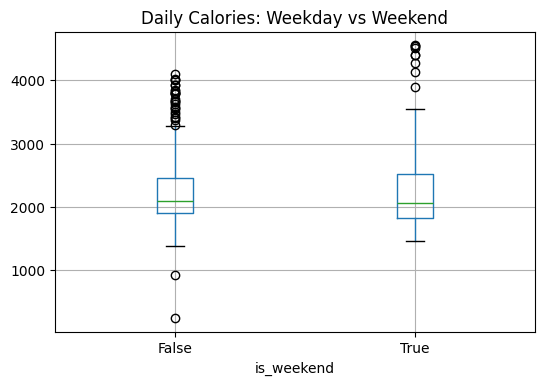

In [20]:
df = calories_merged_df.copy()

df["dayofweek"] = df["ActivityMinute"].dt.dayofweek
# Monday=0, Sunday=6
df["is_weekend"] = df["dayofweek"].isin([5, 6])

daily = (
    df.groupby(["Id", "is_weekend", df["ActivityMinute"].dt.date])["Calories"]
      .sum()
      .reset_index()
)

daily.boxplot(column="Calories", by="is_weekend", figsize=(6,4))
plt.title("Daily Calories: Weekday vs Weekend")
plt.suptitle("")
plt.show()

#### Interpretation

**1. Calories Distribution**
From the calories distribution, we observe that most calories burned per minute fall within the range of approximately 0 to 1.5, forming a right-skewed distribution. This indicates that while most minutes involve low energy expenditure, users occasionally reach much higher calorie burn levels, likely during periods of exercise. Similarly, Steps, METs, and Intensity exhibit comparable right-skewed patterns, reflecting sporadic bursts of higher activity.

**2. Hourly Activity Pattern**
The hourly average plot shows that calorie expenditure is lowest during nighttime hours and higher during daytime, corresponding to typical human activity and rest cycles. This pattern is consistent with expected daily routines and supports the validity of the data.

**3. Weekday vs. Weekend Comparison**
The boxplot comparison indicates that daily calories burned on weekends are slightly higher than on weekdays. This suggests that people may engage in more outdoor or leisure activities on weekends, leading to increased overall energy expenditure compared to weekdays.



### 1.2.3 Features Correlation

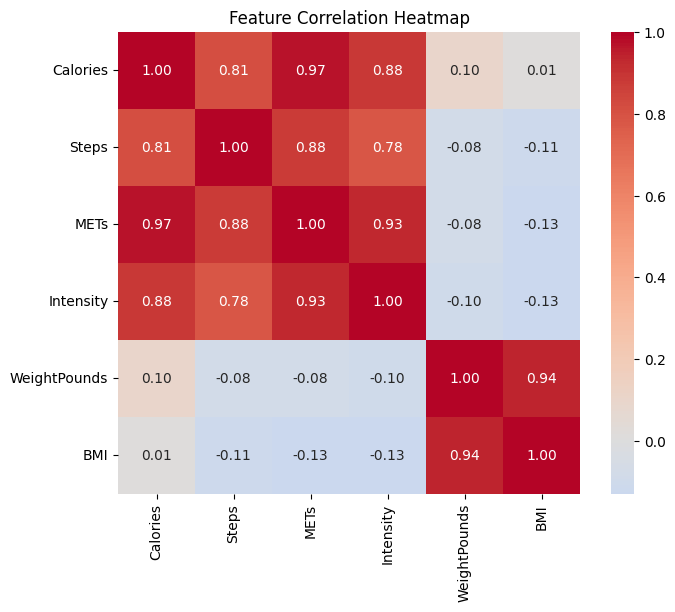

In [21]:
corr = calories_merged_df[
    ['Calories','Steps','METs','Intensity','WeightPounds','BMI']
].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,        # show correlation values
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Feature Correlation Heatmap")
plt.show()

## 1.3 Dataset for sleep status prediction



*   Merge sleep status with heart rate(min, max, avg)/Intensity/METs
*   Split into contiguous segments (per user)
*   Filter long segments




In [22]:
# ensure datetime
raw_hr_sec_df['Time'] = pd.to_datetime(raw_hr_sec_df['Time'])

# drill up to minute
raw_hr_sec_df['ActivityMinute'] = raw_hr_sec_df['Time'].dt.floor('min')

# aggregate
hr_min_df = (
    raw_hr_sec_df.groupby(['Id', 'ActivityMinute'])['Value']
      .agg(
          min_hr='min',
          max_hr='max',
          avg_hr='mean'
      )
      .reset_index()
)

In [23]:
# Merge sleep status with heart rate(min, max, avg)/Intensity/METs
raw_intensities_min_df['ActivityMinute'] = pd.to_datetime(
    raw_intensities_min_df['ActivityMinute']
)

raw_mets_min_df['ActivityMinute'] = pd.to_datetime(
    raw_mets_min_df['ActivityMinute']
)

raw_step_min_df['ActivityMinute'] = pd.to_datetime(
    raw_step_min_df['ActivityMinute']
)

raw_sleep_min_df['date'] = pd.to_datetime(
    raw_sleep_min_df['date'],
    format='%m/%d/%Y %I:%M:%S %p'
)

sleep_status_df = hr_min_df.merge(
    raw_intensities_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

sleep_status_df = sleep_status_df.merge(
    raw_mets_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

sleep_status_df = sleep_status_df.merge(
    raw_step_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

sleep_status_df = sleep_status_df.merge(
    raw_sleep_min_df,
    left_on=['Id', 'ActivityMinute'],
    right_on=['Id', 'date'],
    how='left'
)

/tmp/ipython-input-2205256348.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_intensities_min_df['ActivityMinute'] = pd.to_datetime(
/tmp/ipython-input-2205256348.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_mets_min_df['ActivityMinute'] = pd.to_datetime(
/tmp/ipython-input-2205256348.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_step_min_df['ActivityMinute'] = pd.to_datetime(


In [24]:
sleep_status_df.dropna(inplace=True)
sleep_status_df.drop(columns=['date', 'logId'], inplace=True)
sleep_status_df.isna().sum()

,0
Id,0
ActivityMinute,0
min_hr,0
max_hr,0
avg_hr,0
Intensity,0
METs,0
Steps,0
value,0


In [25]:
# Sort by value
sleep_status_df = sleep_status_df.sort_values(['Id', 'ActivityMinute'], ascending=True)

# Remove duplicated data
sleep_status_df = sleep_status_df.drop_duplicates(subset=['Id', 'ActivityMinute'])
sleep_status_df.dropna(subset=['value'], inplace=True)

# Check minute-level time continuity in the dataset
sleep_status_df.groupby('Id')['ActivityMinute'].diff().value_counts()

,count
ActivityMinute,
0 days 00:01:00,47476
0 days 00:02:00,20
0 days 00:03:00,12
0 days 00:04:00,7
0 days 00:05:00,4
...,...
0 days 16:41:00,1
0 days 17:16:00,1
0 days 00:14:00,1


In [26]:
sleep_status_df['time_diff'] = (
    sleep_status_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
)

In [27]:
# Split into contiguous segments (per user)
sleep_status_df['time_diff'] = (
    sleep_status_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
)

EXPECTED_INTERVAL = 60   # second
THRESHOLD = 60 * 60 * 2  # 2 hours

sleep_status_df['new_segment'] = (
    (sleep_status_df['time_diff'] > THRESHOLD) |
    sleep_status_df['time_diff'].isna()
)

sleep_status_df['segment_id'] = (
    sleep_status_df.groupby('Id')['new_segment']
      .cumsum()
)

sleep_status_df['segment_uid'] = (
    sleep_status_df['Id'].astype(str) + '_' +
    sleep_status_df['segment_id'].astype(str)
)

# Filter long segments
segment_stats = (
    sleep_status_df.groupby(['Id', 'segment_uid'])
      .agg(
          start_time=('ActivityMinute', 'min'),
          end_time=('ActivityMinute', 'max'),
          n_points=('ActivityMinute', 'count')
      )
      .reset_index()
)

segment_stats['duration_sec'] = (
    segment_stats['end_time'] - segment_stats['start_time']
).dt.total_seconds()

valid_segments = segment_stats[
    segment_stats['duration_sec'] >= THRESHOLD
]

sleep_status_merge_df = sleep_status_df.merge(
    valid_segments[['segment_uid']],
    on='segment_uid',
    how='inner'
)

In [28]:
sleep_status_merge_df.groupby('segment_uid')['ActivityMinute'].diff().value_counts().head()

,count
ActivityMinute,
0 days 00:01:00,46773
0 days 00:02:00,18
0 days 00:03:00,12
0 days 00:04:00,7
0 days 00:07:00,4


### 1.3.1 EDA

In [29]:
print(f"""
Number of users: {sleep_status_merge_df['Id'].nunique()}
Number of segments: {sleep_status_merge_df['segment_uid'].nunique()}
Number of points: {sleep_status_merge_df['ActivityMinute'].count()}

Longest segment: {sleep_status_merge_df['segment_uid'].value_counts().max() / 60} hours
Shortest segment: {sleep_status_merge_df['segment_uid'].value_counts().min() / 60} hours
Average segment: {sleep_status_merge_df['segment_uid'].value_counts().mean() / 60} hours
""")


Number of users: 10
Number of segments: 103
Number of points: 46957

Longest segment: 12.066666666666666 hours
Shortest segment: 2.15 hours
Average segment: 7.598220064724918 hours



In [30]:
sleep_status_merge_df.describe()

,Id,ActivityMinute,min_hr,max_hr,avg_hr,Intensity,METs,Steps,value,time_diff,segment_id
count,46957,46957,46957,46957,46957,46957,46957,46957,46957,46948,46957
mean,5776905852,2016-04-26 11:46:49.864769792,60,63,61,0,10,0,1,360,8
min,2347167796,2016-04-12 00:00:00,39,41,40,0,10,0,1,60,1
25%,4388161847,2016-04-18 22:29:00,54,57,55,0,10,0,1,60,4
50%,5577150313,2016-04-27 06:23:00,59,62,61,0,10,0,1,60,7
75%,6962181067,2016-05-04 04:12:00,64,68,66,0,10,0,1,60,12
max,8792009665,2016-05-12 08:00:00,122,128,126,1,70,49,3,1455900,21
std,1716483948,NaN,8,9,9,0,2,1,0,10295,5


<Axes: xlabel='length', ylabel='Count'>

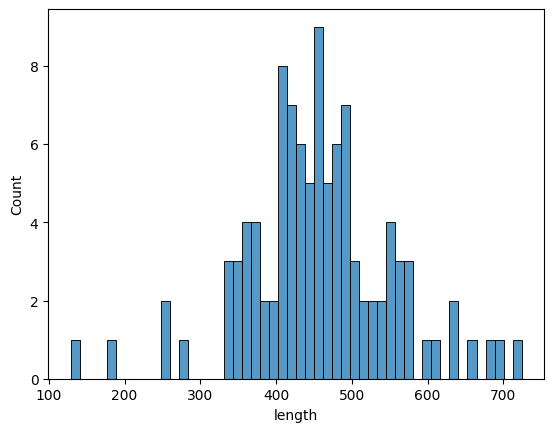

In [31]:
segment_stats = (
    sleep_status_merge_df.groupby(['Id','segment_uid'])
      .size()
      .reset_index(name='length')
)

sns.histplot(segment_stats['length'], bins=50)

In [32]:
sleep_status_merge_df['value'].value_counts().sort_index()


,count
value,
1,44288
2,2254
3,415


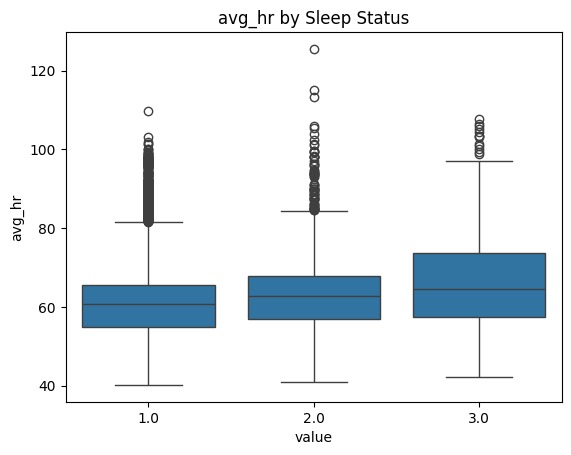

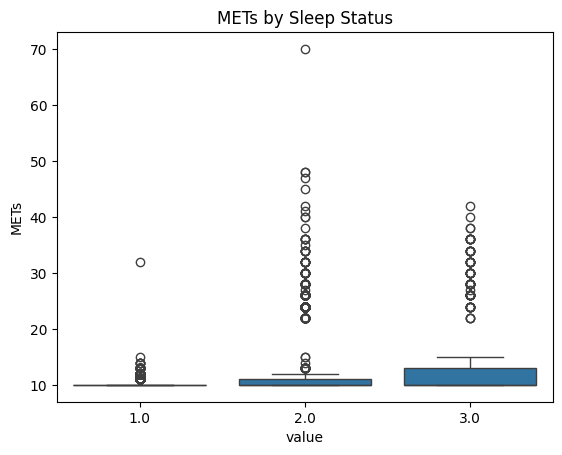

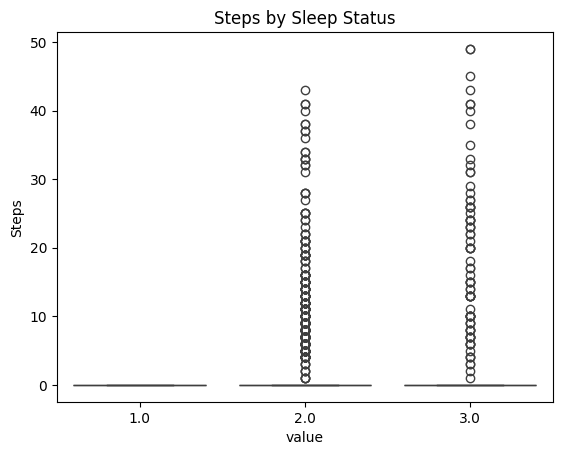

In [33]:
features = ['avg_hr', 'METs', 'Steps']

for f in features:
    sns.boxplot(
        x='value',
        y=f,
        data=sleep_status_merge_df
    )
    plt.title(f'{f} by Sleep Status')
    plt.show()

<Axes: xlabel='hour', ylabel='count'>

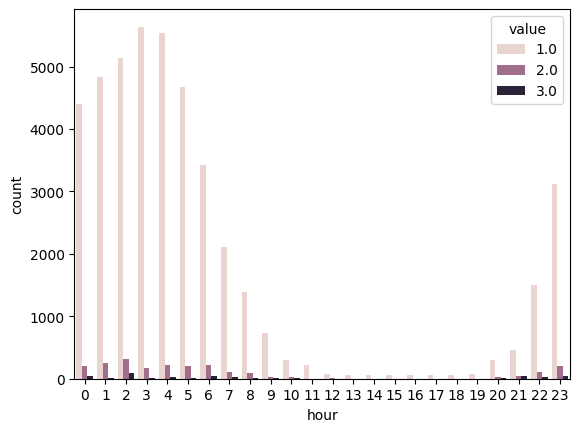

In [34]:
sleep_status_merge_df['hour'] = sleep_status_merge_df['ActivityMinute'].dt.hour

sns.countplot(
    x='hour',
    hue='value',
    data=sleep_status_merge_df
)

<Axes: xlabel='Id'>

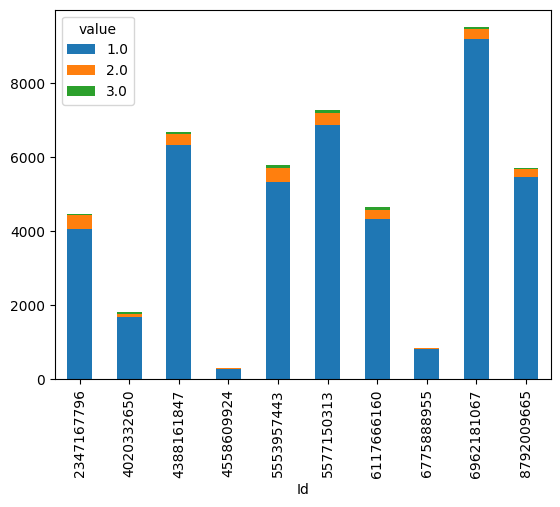

In [35]:
user_sleep_dist = (
    sleep_status_merge_df.groupby(['Id','value'])
           .size()
           .unstack(fill_value=0)
)

user_sleep_dist.plot(kind='bar', stacked=True)

#### Interpretation

In this dataset, sleep status is classified into three device-defined categories:
`1 = Asleep, 2 = Restless, and 3 = Awake`.

From the boxplots, the average heart rate during the `Asleep` state is consistently lower than in the other two states, which aligns with expected physiological patterns during sleep. In contrast, the `Awake` state exhibits significantly higher heart rates and greater variability, reflecting increased physical and mental activity. A similar trend is observed for METs, where activity intensity increases progressively from Asleep to `Awake`.

Notably, the `Restless` state shows a larger number of high-value outliers in both heart rate and `METs`. This suggests intermittent body movements, such as turning or repositioning during sleep, which are captured by wearable sensors as short bursts of activity. Correspondingly, step counts occasionally appear in both Restless and `Awake` states, likely caused by motion artifacts rather than sustained walking behavior.

Temporal distribution analysis indicates that most sleep records occur during nighttime hours, consistent with typical circadian sleep patterns. However, a non-negligible portion of sleep observations is also present during daytime, which may correspond to daytime naps or irregular sleep schedules.

Finally, user-level distributions reveal that most individuals exhibit a dominant `Asleep` state, with fewer observations in `Restless` and Awake states. This consistent pattern across users suggests stable sleep behavior and supports the generalizability of downstream sleep state modeling.





### 1.3.2 Features Correlation

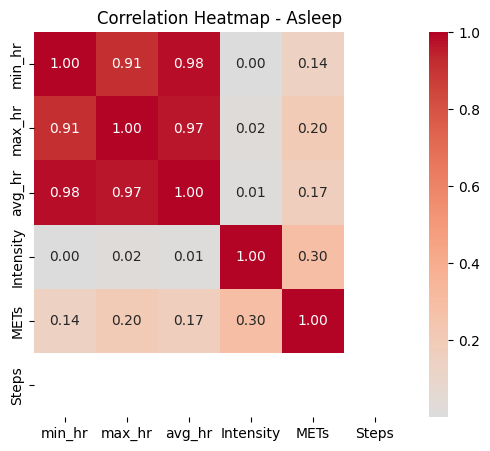

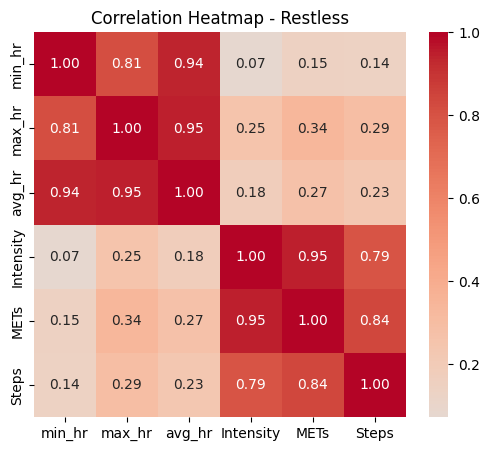

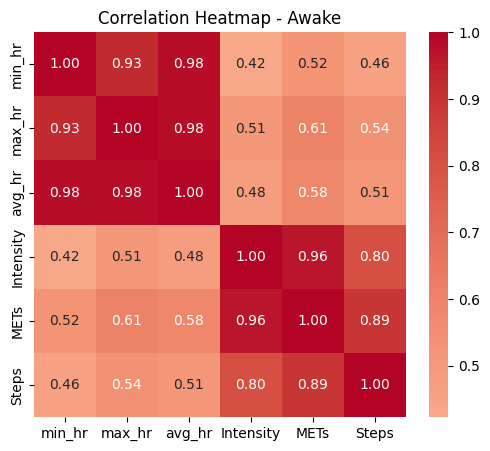

In [36]:
for status, label in {
    1: 'Asleep',
    2: 'Restless',
    3: 'Awake'
}.items():
    corr = (
        sleep_status_merge_df
        .query("value == @status")[['min_hr','max_hr','avg_hr','Intensity','METs','Steps']]
        .corr()
    )

    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(f"Correlation Heatmap - {label}")
    plt.show()

## 1.4 Save cleaned datasets

In [37]:
calories_merged_df[['Id', 'ActivityMinute', 'Calories', 'Intensity', 'METs', 'Steps', 'WeightPounds', 'BMI']]. \
      to_csv(google_drive_path + '/calories_merged_df.csv')
sleep_status_merge_df[['Id', 'ActivityMinute', 'min_hr', 'max_hr', 'avg_hr', 'Intensity', 'METs', 'Steps', 'value', 'segment_uid']]. \
      to_csv(google_drive_path + '/sleep_status_merge_df.csv')

In [ ]:
# load cleaned dataset

# calories_merged_df = pd.read_csv(google_drive_path + '/calories_merged_df.csv')
# sleep_status_merge_df = pd.read_csv(google_drive_path + '/sleep_status_merge_df.csv')
# sleep_status_merge_df

In [38]:
print(sleep_status_merge_df.shape)
sleep_status_merge_df.columns


(46957, 14)


Index(['Id', 'ActivityMinute', 'min_hr', 'max_hr', 'avg_hr', 'Intensity',
       'METs', 'Steps', 'value', 'time_diff', 'new_segment', 'segment_id',
       'segment_uid', 'hour'],
      dtype='object')

# CNN

In [58]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow.keras import layers, models

In [59]:
df = sleep_status_merge_df.copy()
df = df.sort_values(["segment_uid", "ActivityMinute"]).reset_index(drop=True)

df["y_binary"] = (df["value"] != 1).astype(int)

features = ["min_hr", "max_hr", "avg_hr", "Intensity", "METs", "Steps"]

X_raw = df[features].astype(float).values
y_raw = df["y_binary"].values

print("rows:", df.shape)
print("label counts:", np.bincount(y_raw))

rows: (46957, 15)
label counts: [44288  2669]


In [60]:
def make_windows(df_in, X, y, window=30, stride=5):
    Xw, yw, gw = [], [], []
    for seg, idxs in df_in.groupby("segment_uid").indices.items():
        idxs = np.array(sorted(idxs))
        xs = X[idxs]
        ys = y[idxs]
        if len(xs) < window:
            continue
        for i in range(0, len(xs) - window + 1, stride):
            Xw.append(xs[i:i+window])
            yw.append(ys[i+window-1])
            gw.append(seg)
    return np.array(Xw, dtype=np.float32), np.array(yw, dtype=np.int64), np.array(gw)

WINDOW = 30
STRIDE = 5

Xw, yw, gw = make_windows(df, X_raw, y_raw, window=WINDOW, stride=STRIDE)

print("windows:", Xw.shape)
print("window label counts:", np.bincount(yw))
print("num segments:", len(np.unique(gw)))

windows: (8837, 30, 6)
window label counts: [8368  469]
num segments: 103


Note:
After segmenting the data into 30 minute windows with a 5 minute stride, we obtained a total of 8837 windows across 103 unique sleep segments. Each window contains 6 physiological and activity features. Of these windows, 8,368 represent normal sleep and 469 represent disturbed sleep, showing that the dataset remains imbalanced after windowing.

In [61]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr, te = next(gss.split(Xw, yw, groups=gw))

X_train, X_test = Xw[tr], Xw[te]
y_train, y_test = yw[tr], yw[te]

scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_test_2d = X_test.reshape(-1, X_test.shape[-1])

X_train_2d = scaler.fit_transform(X_train_2d)
X_test_2d = scaler.transform(X_test_2d)

X_train = X_train_2d.reshape(X_train.shape)
X_test = X_test_2d.reshape(X_test.shape)

print("train:", X_train.shape, "test:", X_test.shape)
print("train counts:", np.bincount(y_train), "test counts:", np.bincount(y_test))

train: (7091, 30, 6) test: (1746, 30, 6)
train counts: [6731  360] test counts: [1637  109]


Note: To prevent data leakage the dataset was split by segment_uid using GroupShuffleSplit. This makes sure that windows from the same sleep segment do not appear in both the training and testing sets.

In [62]:
counts = np.bincount(y_train)
w0 = 1.0
w1 = float(counts[0] / counts[1]) if counts[1] > 0 else 1.0
class_weight = {0: w0, 1: w1}
class_weight

{0: 1.0, 1: 18.697222222222223}

In [63]:
def build_cnn(input_shape):
    x_in = layers.Input(shape=input_shape)

    x = layers.Conv1D(64, 5, padding="same")(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)

    y_out = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(x_in, y_out)

model = build_cnn((WINDOW, len(features)))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 30, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 30, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 7, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,377 (302.25 KB)

 Trainable params: 76,737 (299.75 KB)

 Non-trainable params: 640 (2.50 KB)

In [64]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6964 - auc: 0.7289 - loss: 1.2375 - val_accuracy: 0.9232 - val_auc: 0.8279 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7063 - auc: 0.7754 - loss: 1.1592 - val_accuracy: 0.9323 - val_auc: 0.8200 - val_loss: 0.4314 - learning_rate: 0.0010
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8082 - auc: 0.8023 - loss: 1.0755 - val_accuracy: 0.9598 - val_auc: 0.8241 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8275 - auc: 0.8405 - loss: 0.9586 - val_accuracy: 0.9394 - val_auc: 0.8498 - val_loss: 0.3672 - learning_rate: 0.0010
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7495 - auc: 0.8260 - loss: 0.9995 - val_accuracy: 0.9049 - val_auc: 0.8564 - val_loss: 0.3989 - learning_rate: 0.0010
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8014 - auc: 0.8543 -

In [65]:
probs = model.predict(X_test).ravel()
pred = (probs >= 0.5).astype(int)

print("Macro F1:", round(f1_score(y_test, pred, average="macro"), 4))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=4))

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Macro F1: 0.7196
[[1550   87]
 [  47   62]]
              precision    recall  f1-score   support

           0     0.9706    0.9469    0.9586      1637
           1     0.4161    0.5688    0.4806       109

    accuracy                         0.9233      1746
   macro avg     0.6933    0.7578    0.7196      1746
weighted avg     0.9360    0.9233    0.9287      1746



## Interpretation
The CNN model achieved a macro F1-score of 0.7196 on the test set. The confusion matrix and classification report show strong performance for detecting normal sleep, with a recall of 94.7% and an F1-score of 0.96. Performance for disturbed sleep was lower, with a recall of 56.9% and an F1-score of 0.48.